# 👥 Group Information

1. **Mahmudur Rahman Mehraj** — ID: 2022-3-60-182  
2. **MD. Robiul Islam** — ID: 2023-1-60-093  
3. **Sunzid Ashraf Mahi** — ID: 2023-1-60-148

# Clear Current Output Directory

In [1]:
!rm -rf /kaggle/working/*

# Imports

In [2]:
!pip install -q ultralytics --no-deps

import os
import cv2
import glob
import yaml
import torch
import random
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from ultralytics import YOLO
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# HyperParameters

In [3]:
LABELED_RATIO = 0.20       
CONF_THRESHOLD = 0.70  
IMG_SIZE = 640
SEED = 42

# Teacher Settings
TEACHER_MODEL = "yolo12n.pt"
TEACHER_EPOCHS = 50
TEACHER_BATCH = 64

# Student Settings
STUDENT_MODEL = "yolo12n.pt"
STUDENT_EPOCHS = 100
STUDENT_BATCH = 64

# Fine Tune Settings
FINE_TUNE_EPOCHS = 50

# Configuration

In [4]:
INPUT_ROOT = f"/kaggle/input/object-detection-ewu" 

WORKING_DIR = "/kaggle/working"

# GPU Selection
DEVICE = [0, 1]

random.seed(SEED)
torch.manual_seed(SEED)

print("Configuration Loaded.")
print(f"Dataset Root at: {INPUT_ROOT}")

Configuration Loaded.
Dataset Root at: /kaggle/input/object-detection-ewu


# Utilities

In [5]:
def make_dir(path):
    """Creates a directory if it doesn't exist."""
    if os.path.exists(path):
        shutil.rmtree(path) 
    os.makedirs(path)

def copy_files(image_paths, source_label_dir, dest_img_dir, dest_lbl_dir, copy_labels=True):
    """Copies images and their matching labels."""
    count = 0
    for img_path in image_paths:
        shutil.copy(img_path, dest_img_dir)
        
        if copy_labels:
            filename = os.path.basename(img_path)
            label_name = os.path.splitext(filename)[0] + ".txt"
            src_label_path = os.path.join(source_label_dir, label_name)
            
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dest_lbl_dir)
                count += 1
            else:
                print(f"Warning: Label not found for {filename}")
    return count

print("Utilities ready.")

Utilities ready.


# Data Splitting

In [6]:
# 3. Create Required Directories
LABELED_DIR = os.path.join(WORKING_DIR, "ssl_labeled")
UNLABELED_DIR = os.path.join(WORKING_DIR, "ssl_unlabeled")

make_dir(os.path.join(LABELED_DIR, "images"))
make_dir(os.path.join(LABELED_DIR, "labels"))
make_dir(os.path.join(UNLABELED_DIR, "images"))

# 2. Find Images in Kaggle Input
source_train_imgs = glob.glob(os.path.join(INPUT_ROOT, "**", "train", "images", "*.jpg"), recursive=True)
if not source_train_imgs:
    source_train_imgs = glob.glob(os.path.join(INPUT_ROOT, "**", "train", "images", "*.png"), recursive=True)

print(f"Found {len(source_train_imgs)} original training images.")

# 3. Locate the Source Label Directory
first_img_dir = os.path.dirname(source_train_imgs[0])
source_train_lbls_dir = first_img_dir.replace("images", "labels")

# 4. Train/Test - 80/20 Split
labeled_imgs, unlabeled_imgs = train_test_split(
    source_train_imgs, train_size=LABELED_RATIO, random_state=SEED, shuffle=True
)

print(f"Splitting data: {len(labeled_imgs)} Labeled (Teacher) vs {len(unlabeled_imgs)} Unlabeled (Pool)")

# 5. Copy Data to Working Directory
print("Copying Labeled Data...")
copy_files(labeled_imgs, source_train_lbls_dir, 
           os.path.join(LABELED_DIR, "images"), 
           os.path.join(LABELED_DIR, "labels"), 
           copy_labels=True)

print("Copying Unlabeled Data (Images only)...")
copy_files(unlabeled_imgs, source_train_lbls_dir, 
           os.path.join(UNLABELED_DIR, "images"), 
           None, 
           copy_labels=False)

print("Data preparation done.")

Found 7023 original training images.
Splitting data: 1404 Labeled (Teacher) vs 5619 Unlabeled (Pool)
Copying Labeled Data...
Copying Unlabeled Data (Images only)...
Data preparation done.


# Teacher Training

In [7]:
# 1. Find and read the original data.yaml
def get_classes_from_dataset(root_path):
    yaml_files = glob.glob(os.path.join(root_path, "**", "*.yaml"), recursive=True)
    
    for y_file in yaml_files:
        with open(y_file, 'r') as f:
            data = yaml.safe_load(f)
            if data and 'names' in data:
                print(f"✅ Found class names in: {y_file}")
                return data['names']
    
    print("⚠️ Warning: Could not find 'names' in any data.yaml. Using fallback.")
    return None

# 2. Get the Classes
CLASS_NAMES = get_classes_from_dataset(INPUT_ROOT)

if CLASS_NAMES is None:
    CLASS_NAMES = {i: f"class_{i}" for i in range(80)}

# 3. Create Teacher Config (YAML)
teacher_yaml_path = os.path.join(WORKING_DIR, "teacher.yaml")

# 4. Get Valid/Test paths
valid_imgs_path = glob.glob(os.path.join(INPUT_ROOT, "**", "valid", "images"), recursive=True)
valid_imgs_path = valid_imgs_path[0] if valid_imgs_path else None

test_imgs_path = glob.glob(os.path.join(INPUT_ROOT, "**", "test", "images"), recursive=True)
test_imgs_path = test_imgs_path[0] if test_imgs_path else None

yaml_data = {
    'path': WORKING_DIR,
    'train': os.path.join(LABELED_DIR, "images"),
    'val': valid_imgs_path, 
    'test': test_imgs_path,
    'names': CLASS_NAMES    
}

# 5. Write the new config file
with open(teacher_yaml_path, 'w') as f:
    yaml.dump(yaml_data, f)

print(f"Teacher Config Saved. Number of classes: {len(CLASS_NAMES)}")

# 6. Train Teacher
print(f"Training Teacher on {LABELED_RATIO*100}% of data...")
teacher = YOLO(TEACHER_MODEL)

teacher.train(
    data=teacher_yaml_path,
    epochs=TEACHER_EPOCHS,
    imgsz=IMG_SIZE,
    batch=TEACHER_BATCH,
    device=DEVICE,       
    project="runs",
    name="teacher_run",
    verbose=True
)

✅ Found class names in: /kaggle/input/object-detection-ewu/data.yaml
Teacher Config Saved. Number of classes: 22
Training Teacher on 20.0% of data...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/teacher.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        551       2464      0.587      0.692      0.679      0.556
                   Bin         25         25          0          0          0          0
       Building Pillar         73        193      0.638      0.829      0.816      0.563
                   Bus         53         61      0.691      0.916      0.894        0.8
                   CNG         44         56      0.711      0.911       0.92      0.834
                   Car        157        332      0.818      0.774      0.847      0.728
                 Cycle         40         41      0.812      0.633      0.716       0.54
         Electric Pole        101        107      0.653      0.862      0.795      0.576
              Food Van         14         15      0.542      0.733      0.683      0.556
             Food cart          4          4      0.624      0.437      0.469      0.362
              Footpath        184        186      0.875      0.937      0.954      0.815
                Legun

# Generate Pseudo Labels

In [8]:
# 1. Setup Directories
PSEUDO_DIR = os.path.join(WORKING_DIR, "pseudo_data")

if os.path.exists(PSEUDO_DIR):
    shutil.rmtree(PSEUDO_DIR)
    
make_dir(os.path.join(PSEUDO_DIR, "images")) 
make_dir(os.path.join(PSEUDO_DIR, "labels")) 

# Load Best Teacher Weights
teacher_weights = "runs/teacher_run/weights/best.pt"
best_teacher = YOLO(teacher_weights)

print("Running Inference on Unlabeled Pool...")
print(f"Using Confidence Threshold: {CONF_THRESHOLD}")

# 2. Run Inference
results = best_teacher.predict(
    source=os.path.join(UNLABELED_DIR, "images"),
    conf=CONF_THRESHOLD,
    imgsz=IMG_SIZE,
    stream=True,    
    verbose=False
)

count = 0

# 3. Process Results Correctly
print("Processing predictions...")
for result in tqdm(results, desc="Generating Labels"):
    if len(result.boxes) > 0:
        source_img_path = result.path 
        
        # Create filenames
        img_name = os.path.basename(source_img_path)
        txt_name = os.path.splitext(img_name)[0] + ".txt"
        
        # Save Label
        save_label_path = os.path.join(PSEUDO_DIR, "labels", txt_name)
        with open(save_label_path, 'w') as f:
            for box in result.boxes:
                # Get class and normalized xywh
                cls = int(box.cls[0])
                x, y, w, h = box.xywhn[0].tolist()
                f.write(f"{cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        
        # Save Image
        shutil.copy(source_img_path, os.path.join(PSEUDO_DIR, "images", img_name))
        
        count += 1

print(f"\n✅ Pseudo-labeling finished.")
print(f"Useful Labels Generated: {count}")

Running Inference on Unlabeled Pool...
Using Confidence Threshold: 0.7
Processing predictions...


Generating Labels: 0it [00:00, ?it/s]


✅ Pseudo-labeling finished.
Useful Labels Generated: 5535


# Merge Datasets

In [9]:
STUDENT_DATA_DIR = os.path.join(WORKING_DIR, "student_dataset")
make_dir(os.path.join(STUDENT_DATA_DIR, "images"))
make_dir(os.path.join(STUDENT_DATA_DIR, "labels"))

print("Merging datasets...")

# 1. Copy Original Labeled Data (Images + Labels)
for f in glob.glob(os.path.join(LABELED_DIR, "images", "*")):
    shutil.copy(f, os.path.join(STUDENT_DATA_DIR, "images"))
for f in glob.glob(os.path.join(LABELED_DIR, "labels", "*")):
    shutil.copy(f, os.path.join(STUDENT_DATA_DIR, "labels"))

# 2. Copy Unlabeled Images + New Pseudo Labels
pseudo_labels = glob.glob(os.path.join(PSEUDO_DIR, "labels", "*.txt"))

for label_file in pseudo_labels:
    # Copy the label
    shutil.copy(label_file, os.path.join(STUDENT_DATA_DIR, "labels"))
    
    # Find matching image in UNLABELED_DIR and copy it
    base_name = os.path.splitext(os.path.basename(label_file))[0]
    img_src = os.path.join(UNLABELED_DIR, "images", base_name + ".jpg") 
    
    if os.path.exists(img_src):
        shutil.copy(img_src, os.path.join(STUDENT_DATA_DIR, "images"))

# Count
total_train = len(glob.glob(os.path.join(STUDENT_DATA_DIR, "images", "*")))
print(f"Student Dataset Ready. Total Images: {total_train}")

Merging datasets...
Student Dataset Ready. Total Images: 6939


# Student Training

In [10]:
# 1. Create Student Config
student_yaml_path = os.path.join(WORKING_DIR, "student.yaml")

yaml_data['train'] = os.path.join(STUDENT_DATA_DIR, "images")

with open(student_yaml_path, 'w') as f:
    yaml.dump(yaml_data, f)

# 2. Train Student
print("Starting Student Training...")
student = YOLO(STUDENT_MODEL)

student.train(
    data=student_yaml_path,
    epochs=STUDENT_EPOCHS,
    imgsz=IMG_SIZE,
    batch=STUDENT_BATCH,
    device=DEVICE,
    project="runs",
    name="student_run",
    
    # Augmentations
    mosaic=1.0,
    mixup=0.1,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    fliplr=0.5
)

print("Pipeline Complete. Check runs/student_run for results.")

Starting Student Training...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/student.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=student_run, nbs=64, nms=F

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        551       2464      0.717      0.629      0.683      0.566
                   Bin         25         25          0          0          0          0
       Building Pillar         73        193      0.773      0.618      0.742       0.54
                   Bus         53         61      0.829      0.885      0.919      0.843
                   CNG         44         56      0.811      0.911      0.911      0.849
                   Car        157        332      0.871      0.714      0.836      0.748
                 Cycle         40         41      0.953       0.49      0.756       0.59
         Electric Pole        101        107      0.721      0.775      0.796      0.619
              Food Van         14         15      0.724      0.667      0.777      0.638
             Food cart          4          4          1          0      0.255      0.178
              Footpath        184        186       0.92      0.934      0.965      0.842
                Legun

# Fine Tuning

In [11]:
print("Starting Fine-Tuning on Labeled Data...")

# 1. Load Best Student Weights
student_weights = f"{WORKING_DIR}/runs/student_run/weights/best.pt" 
finetune_model = YOLO(student_weights)

# 2. Train on Original Labeled Data
finetune_model.train(
    data = os.path.join(WORKING_DIR, "teacher.yaml"),
    epochs = FINE_TUNE_EPOCHS,            
    imgsz = IMG_SIZE,
    batch = STUDENT_BATCH,
    lr0 = 0.005,             
    device = DEVICE,
    project = "runs",
    name = "finetune_run"   
)

Starting Fine-Tuning on Labeled Data...
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/teacher.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/runs/student_run/weights/best.pt, momentum=0.937, mosaic=1.0, m

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        551       2464      0.677      0.616      0.682      0.569
                   Bin         25         25          0          0          0          0
       Building Pillar         73        193      0.807      0.539      0.682      0.486
                   Bus         53         61      0.868      0.869      0.908      0.829
                   CNG         44         56       0.76      0.911      0.912      0.853
                   Car        157        332      0.845      0.708      0.828       0.73
                 Cycle         40         41      0.949       0.45      0.728      0.572
         Electric Pole        101        107      0.779      0.693      0.762      0.607
              Food Van         14         15      0.698      0.733      0.784      0.632
             Food cart          4          4      0.185      0.139      0.352      0.251
              Footpath        184        186       0.86      0.941      0.958       0.82
                Legun

# Evaluation

## Loss Curves

✅ Loss Curves saved to: /kaggle/working/runs/student_run/training_curves.png


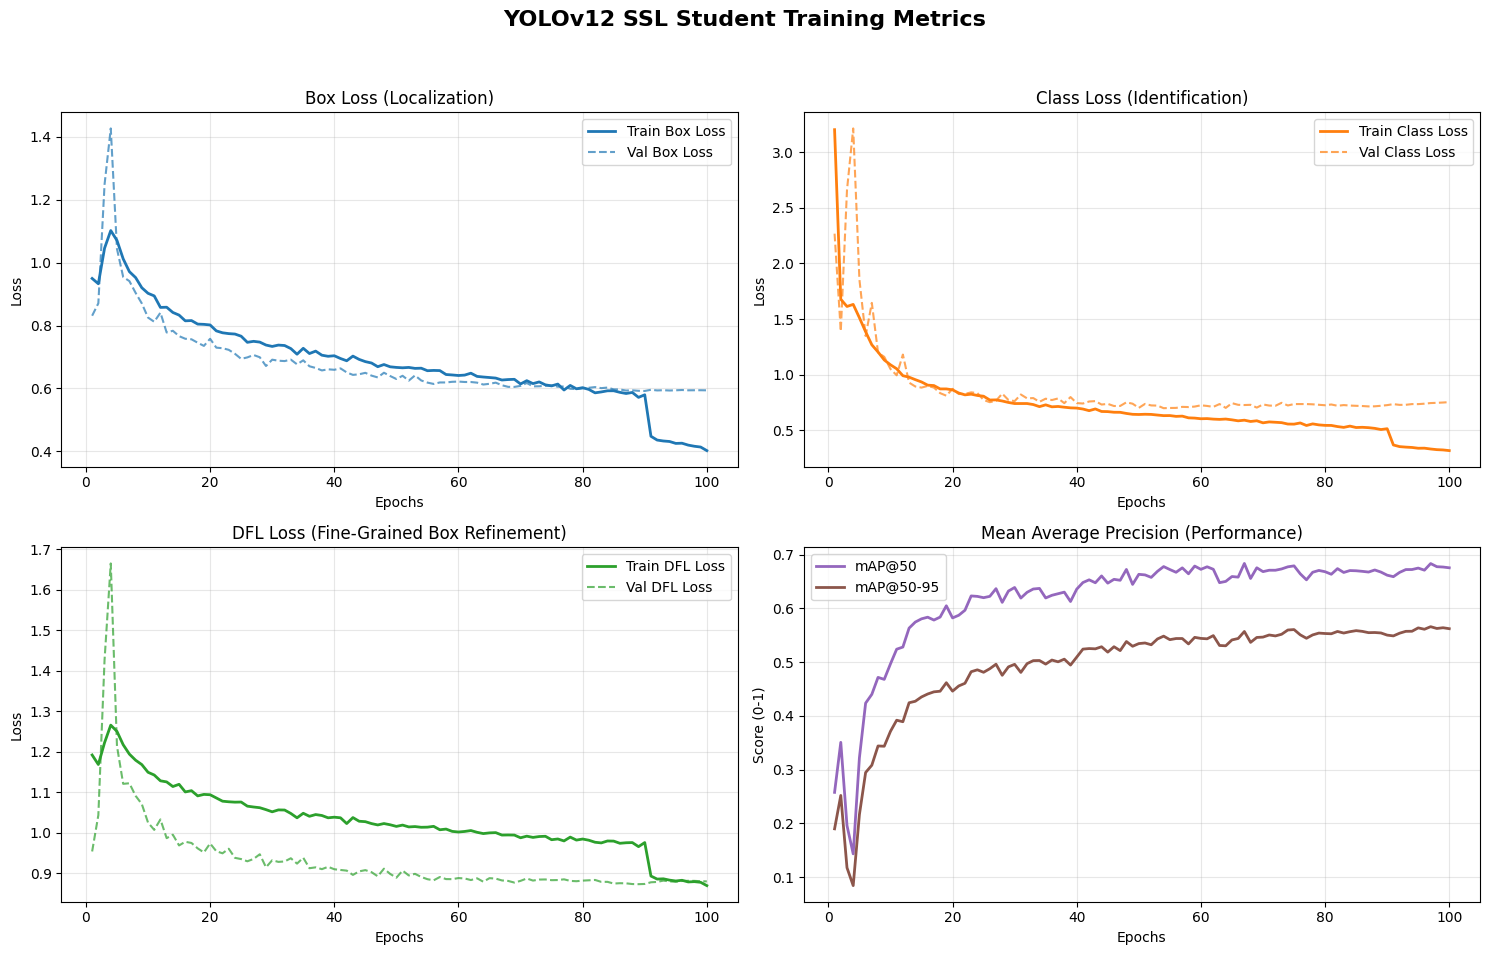

In [12]:
WORK_DIR = Path(WORKING_DIR)
RESULTS_DIR = WORK_DIR / "runs" 
STUDENT_RESULTS_CSV = RESULTS_DIR / "student_run" / "results.csv"

def plot_training_curves(csv_file):
    if not csv_file.exists():
        print(f"❌ Error: Results file not found at {csv_file}")
        return

    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()
    
    epochs = df['epoch']
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('YOLOv12 SSL Student Training Metrics', fontsize=16, fontweight='bold')
    
    # --- A. BOX LOSS ---
    axs[0, 0].plot(epochs, df['train/box_loss'], label='Train Box Loss', color='#1f77b4', linewidth=2)
    if 'val/box_loss' in df.columns:
        axs[0, 0].plot(epochs, df['val/box_loss'], label='Val Box Loss', color='#1f77b4', linestyle='--', alpha=0.7)
    axs[0, 0].set_title('Box Loss (Localization)')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # --- B. CLASS LOSS ---
    axs[0, 1].plot(epochs, df['train/cls_loss'], label='Train Class Loss', color='#ff7f0e', linewidth=2)
    if 'val/cls_loss' in df.columns:
        axs[0, 1].plot(epochs, df['val/cls_loss'], label='Val Class Loss', color='#ff7f0e', linestyle='--', alpha=0.7)
    axs[0, 1].set_title('Class Loss (Identification)')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # --- C. DFL LOSS ---
    axs[1, 0].plot(epochs, df['train/dfl_loss'], label='Train DFL Loss', color='#2ca02c', linewidth=2)
    if 'val/dfl_loss' in df.columns:
        axs[1, 0].plot(epochs, df['val/dfl_loss'], label='Val DFL Loss', color='#2ca02c', linestyle='--', alpha=0.7)
    axs[1, 0].set_title('DFL Loss (Fine-Grained Box Refinement)')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # --- D. MEAN AVERAGE PRECISION (mAP) ---
    axs[1, 1].plot(epochs, df['metrics/mAP50(B)'], label='mAP@50', color='#9467bd', linewidth=2)
    axs[1, 1].plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@50-95', color='#8c564b', linewidth=2)
    axs[1, 1].set_title('Mean Average Precision (Performance)')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Score (0-1)')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Save the plot
    save_path = csv_file.parent / "training_curves.png"
    plt.savefig(save_path, dpi=300)
    print(f"✅ Loss Curves saved to: {save_path}")
    plt.show()

plot_training_curves(STUDENT_RESULTS_CSV)

## Visualization


Loading Teacher Model from: /kaggle/working/runs/teacher_run/weights/best.pt

--- Running Validation on Test Set (Teacher) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,561,018 parameters, 0 gradients
val: Fast image access ✅ (ping: 2.3±1.0 ms, read: 10.9±2.3 MB/s, size: 74.3 KB)
val: Scanning /kaggle/input/object-detection-ewu/test/labels... 540 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 540/540 247.1it/s 2.2s
WARNING ⚠️ val: Cache directory /kaggle/input/object-detection-ewu/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.0it/s 8.7s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        540       2899      0.683      0.666      0.691      0.563
                   Bin         26         38          0          0          0          0
       Building Pillar         72        182      0.657      0.775      0.778      0.576
                   Bus         31         39      0.812      0.886      0.877      0.736
                   CNG        114        147      0.894      0.884      0.929      0.823
                   Car        217        495      0.899      0.846      0.928      0.808
                 Cycle         18         18      0.691      0.374      0.496      0.445
         Electric Pole         79         93      0.547      0.624      0.597      0.403
              Food Van         10         12      0.899      0.667       0.81      0.727
             Food cart         22         31      0.668      0.742      0.717      0.603
              Footpath        120        132      0.795       0.88      0.874      0.699
                Legun

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        540       2899       0.74      0.601      0.691      0.564
                   Bin         26         38          0          0          0          0
       Building Pillar         72        182      0.804      0.542      0.662      0.481
                   Bus         31         39      0.878      0.872      0.927      0.809
                   CNG        114        147      0.873      0.864      0.909      0.802
                   Car        217        495      0.926      0.808      0.917      0.804
                 Cycle         18         18      0.836      0.389      0.474      0.407
         Electric Pole         79         93      0.695      0.355       0.55      0.403
              Food Van         10         12      0.886      0.647      0.812       0.67
             Food cart         22         31      0.794      0.806      0.764      0.611
              Footpath        120        132      0.753      0.886      0.888      0.723
                Legun

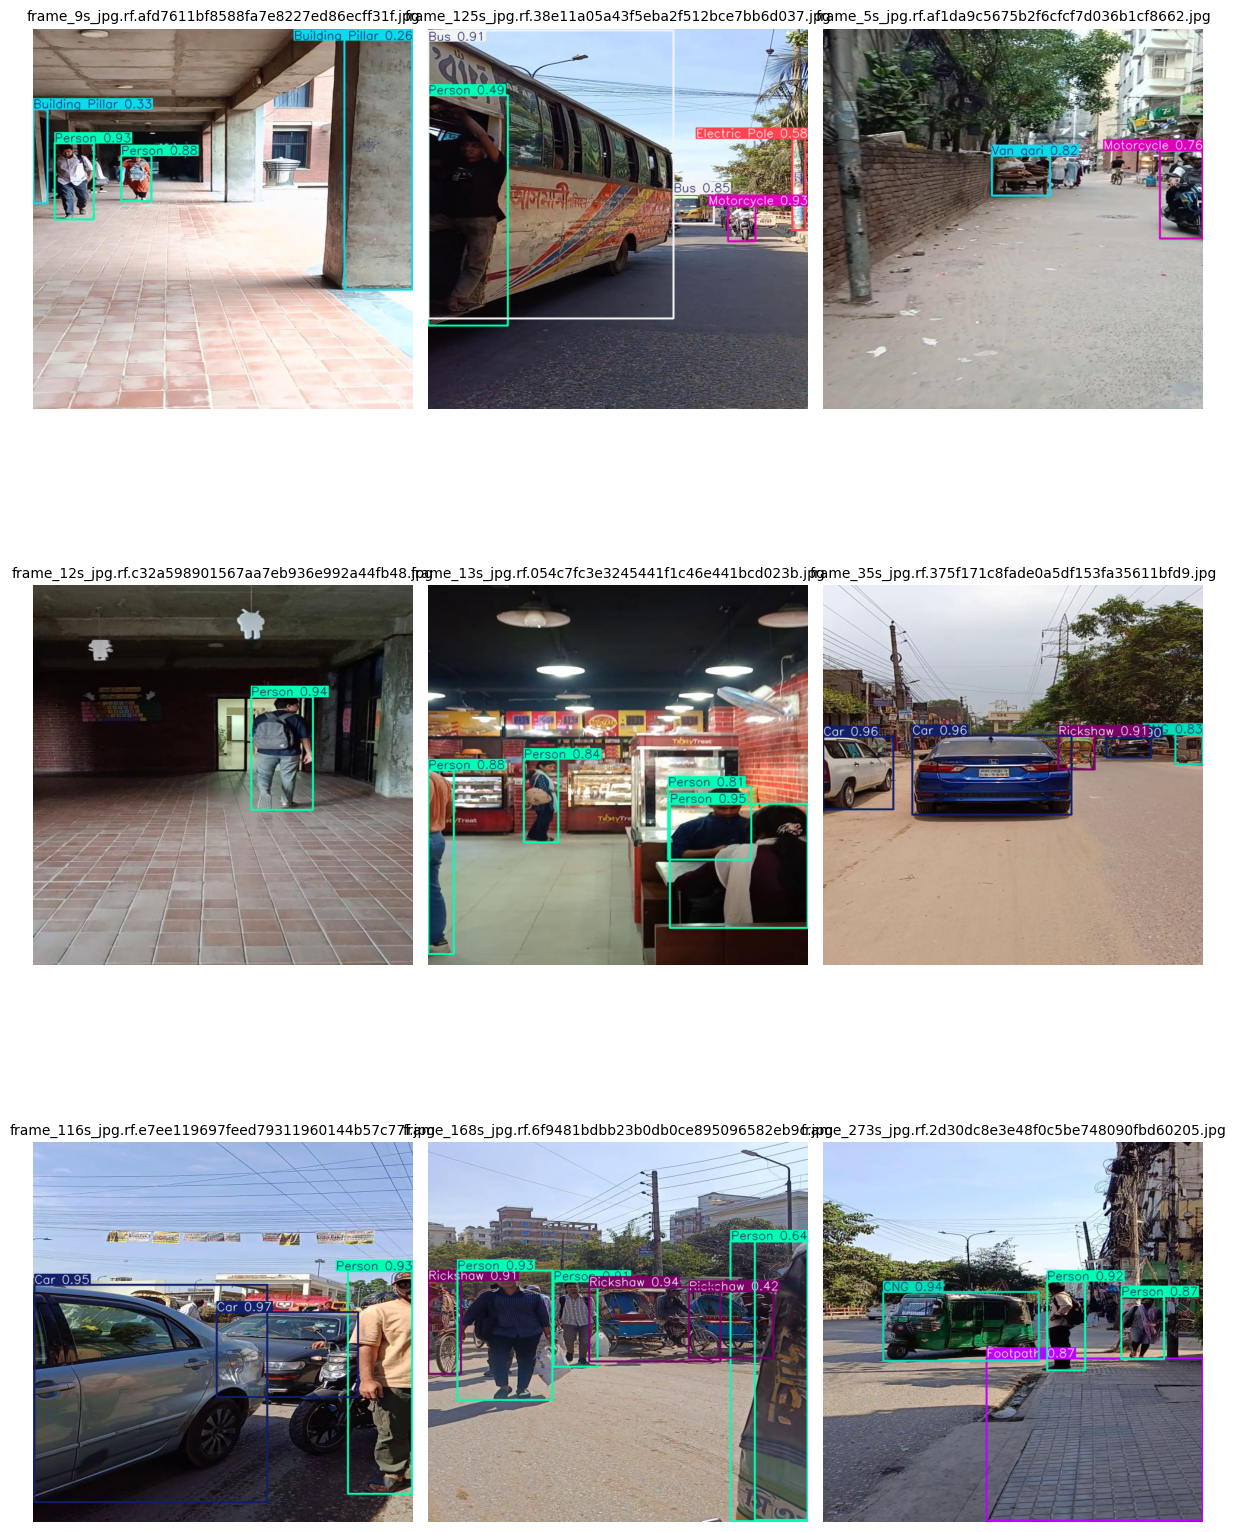

In [13]:

# Best Weights Path
teacher_pt = RESULTS_DIR / 'teacher_run/weights/best.pt'
student_pt = RESULTS_DIR / 'finetune_run/weights/best.pt'
teacher_yaml_path = WORK_DIR / "teacher.yaml"
student_yaml_path = WORK_DIR / "student.yaml"

# Teacher Model Evaluation
print(f"\nLoading Teacher Model from: {teacher_pt}")
model_teacher = YOLO(str(teacher_pt))

print("\n--- Running Validation on Test Set (Teacher) ---")
results_t = model_teacher.val(data=str(teacher_yaml_path),
                              imgsz=IMG_SIZE,
                              batch=TEACHER_BATCH,
                              split='test',
                              save=True,               
                              project=str(RESULTS_DIR),
                              name='teacher_val')      

# Extract Metrics
try:
    t_mp, t_mr, t_map50, t_map5095 = results_t.mean_results()
except Exception:
    t_mp, t_mr = results_t.box.mp, results_t.box.mr
    t_map50, t_map5095 = results_t.box.map50, results_t.box.map

t_mf1 = (2 * t_mp * t_mr) / (t_mp + t_mr) if (t_mp + t_mr) > 0 else 0.0

print("\nTeacher Validation Metrics:")
print(f" Precision (mP) : {t_mp:.4f}")
print(f" Recall    (mR) : {t_mr:.4f}")
print(f" F1 Score       : {t_mf1:.4f}")
print(f" mAP@0.50       : {t_map50:.4f}")
print(f" mAP@0.50-0.95  : {t_map5095:.4f}")

# Student Model Evaluation
print(f"Loading Student Model from: {student_pt}")
model_det = YOLO(str(student_pt))

print("\n--- Running Validation on Test Set (Student) ---")
results = model_det.val(data=str(student_yaml_path),
                        imgsz=IMG_SIZE,
                        batch=STUDENT_BATCH,
                        split='test',
                        save=True,                
                        project=str(RESULTS_DIR), 
                        name='student_val')      

# Extract Metrics
try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = results.box.mp, results.box.mr
    map50, map5095 = results.box.map50, results.box.map

mf1 = (2 * mp * mr) / (mp + mr) if (mp + mr) > 0 else 0.0

print("\nStudent Validation Metrics:")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" F1 Score       : {mf1:.4f}")
print(f" mAP@0.50       : {map50:.4f}")
print(f" mAP@0.50-0.95  : {map5095:.4f}")

print(f"\n Evaluation Plots saved to: {RESULTS_DIR}/student_val and {RESULTS_DIR}/teacher_val")

# 2. Visualize Predictions
test_imgs_path = Path(INPUT_ROOT) / "test" / "images"
if not test_imgs_path.exists():
    test_imgs = list(Path(INPUT_ROOT).glob("**/test/images/*.*"))
else:
    test_imgs = list(test_imgs_path.glob("*.*"))

if test_imgs:
    n_show = min(9, len(test_imgs))
    selected_imgs = random.sample(test_imgs, n_show)

    fig, axes = plt.subplots(3, 3, figsize=(12, 18))
    axes = axes.flatten()

    print(f"\nVisualizing Predictions on {n_show} Test Images...")
    for ax, img_path in zip(axes, selected_imgs):
        pred = model_det.predict(
            source=str(img_path),
            imgsz=IMG_SIZE,
            conf=0.25,
            verbose=False
        )[0]
        
        # Plot BGR to RGB
        res_plot = pred.plot()[:, :, ::-1]
        ax.imshow(res_plot) 
        ax.set_title(img_path.name, fontsize=10)
        ax.axis("off")

    for ax in axes[len(selected_imgs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("❌ No test images found for visualization.")

## XAI

Installing XAI dependencies...
Cloning into '/kaggle/working/YOLO-V12-CAM'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 168 (delta 39), reused 21 (delta 11), pack-reused 99 (from 2)
Receiving objects: 100% (168/168), 52.67 MiB | 43.67 MiB/s, done.
Resolving deltas: 100% (70/70), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0

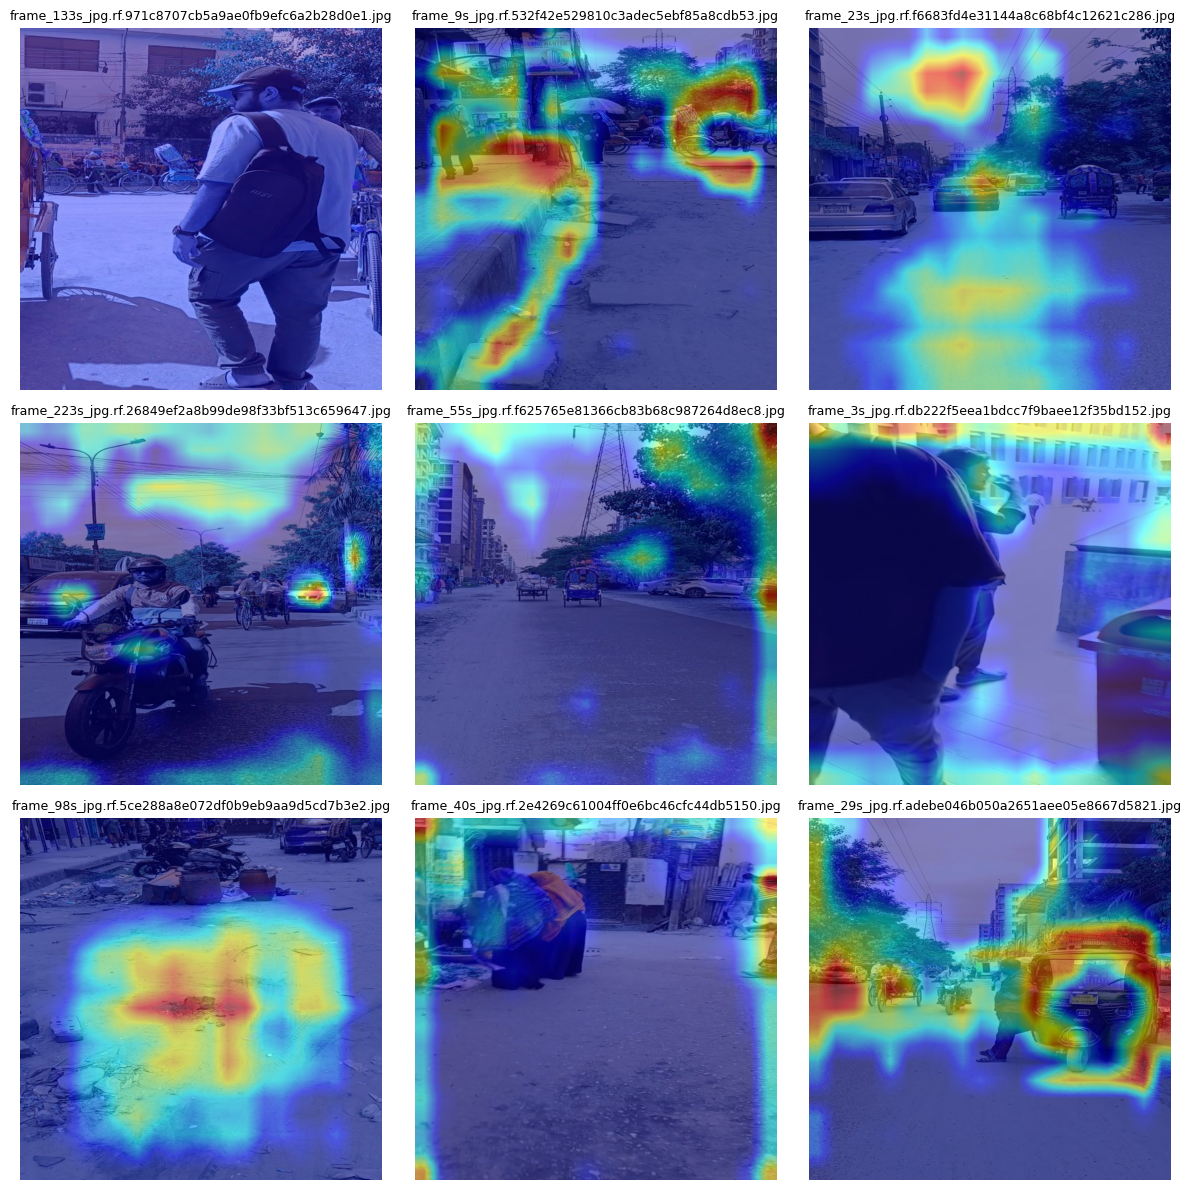

In [14]:
# 1. Setup Environment for CAM
print("Installing XAI dependencies...")

!git clone https://github.com/rigvedrs/YOLO-V12-CAM.git /kaggle/working/YOLO-V12-CAM
!pip install -q grad-cam ttach

# 2. Switch directory to import modules
import sys
sys.path.append("/kaggle/working/YOLO-V12-CAM")
import os
os.chdir("/kaggle/working/YOLO-V12-CAM")

from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image

# 3. Load Model
best_pt = RESULTS_DIR / 'finetune_run/weights/best.pt'
model = YOLO(str(best_pt))

target_layers = [model.model.model[-2]]

cam = EigenCAM(model, target_layers, task='od')

if test_imgs:
    n_show = min(9, len(test_imgs))
    selected_imgs = random.sample(test_imgs, n_show)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    print(f"🚀 Generating EigenCAM Heatmaps for {n_show} images...")

    for ax, img_path in zip(axes, selected_imgs):
        img = cv2.imread(str(img_path))
        if img is None: continue
        
        img = cv2.resize(img, (640, 640))
        
        rgb_img = img.copy()
        img_normalized = np.float32(img) / 255
        
        # Generate CAM
        grayscale_cam = cam(rgb_img)[0, :, :]
        
        # Overlay
        cam_image = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)
        
        ax.imshow(cam_image)
        ax.set_title(img_path.name, fontsize=9)
        ax.axis("off")

    for ax in axes[len(selected_imgs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("❌ No test images found for XAI.")
    
os.chdir(WORKING_DIR)